# **Soni - do:  Generating Music with Artificial Intelligence**


#### Author: Sonia Cobo
#### Date: July 2021

<table align="center"> 
<tr><td width="800"><img src="../resources/title.jpeg" style="width:10;height:10"></td>  
</table>

### Music is associated with emotions, experiences and creativity, all o them considered human's qualities. 

### Though this project doesn't have a hypothesis per se it has been done to prove that technology has advanced to the point where artificial intelligence, that cannot experience these feelings, can generate music.

### This project will explain and show how music has been generated using differente types of neural networks in Python. For this aim different types of neural networks have been analised. Two Long short-term memory (LSTM) models (a Bidirectional and a Unidirectional network) and a Generative adversarial network (GAN) considering different layers and parameters.

# Data

### Music files have been imported to Python in MIDI format. MIDI (Musical Instrument Digital Interface) is a technical standard that describes a communications protocol, digital interface, and electrical connectors that connect a wide variety of electronic musical instruments and computers. They don't contain actual audio data and are small in size. They explain what notes are played, when they're played, and how long or loud each note should be.

### To optimise results only MIDI files consisting of a single instrument were chosen. In this case, the chosen instrument is piano and the type of songs is classical. 

### These songs have been obtained from the following datasets: http://www.piano-midi.de/ and https://www.mfiles.co.uk/classical-midi.htm
### As guidance for the project the following example was considered: 'How to Generate Music using a LSTM Neural Network in Keras' by Sigurður Skúli.


## Import all libraries

In [24]:
# data manipulation
import numpy as np
import pandas as pd 
from collections import Counter


# manipulate midi files
import glob
from music21 import *
import pygame

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# route files
import os
import sys

# ml model
import pickle

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation

# my libraries
import utils.mining_data_tb as md
from utils.folders_tb import read_json
import utils.visualization_tb as vis
import utils.models as m
import utils.apis_tb as a

import warnings
warnings.filterwarnings("ignore")


## Paths

In [25]:
sep = os.sep
# path to raw data
path = md.route(1) + sep + "data" + sep + "raw_data" + sep
# path to data in the right key
path_1 = md.route(1) + sep + "data" + sep + "converted_data" + sep
# path to compiled notes list
path_2 = md.route(1) + sep + "data" + sep + "notes" + sep
# path to generated models
path_3 = md.route(1) + sep + "models" + sep
# path to generated midi files
path_4 = md.route(1) + sep + "reports" + sep
# path to output information
path_5 = md.route(1) + sep + "data" + sep + "output" + sep
# path to other songs
path_6 = md.route(1) + sep + "data" + sep + "more_inst_data" + sep
# path to resources
path_7 = md.route(1) + sep + "resources" + sep



## EDA

### The Python library 'Music21' has been used to read and manipulate MIDI files. This library has the necessary classes to allow us to read music. 

### To start working with MIDI files these need to be converted to Score objects, which are a subclass for handling multi-part music. Once this is done it is possible to use the library build-in classes to view the file information.  

### The main components to generate new melodies, and those considered in this project, are notes, rests and chords. To make prediccions more accurate more components could be considered, such us the time signature. However, due to this project's limitations (timeframe, computer memory, etc) they haven't been included in this study.

### Note objects contain information about the pitch, octave, and offset of the note. Pitch refers to the frequency of the sound, or how high or low it is and is represented with the letters [A, B, C, D, E, F, G] or [Do, Re, Mi, Fa, Sol, La, Si] in Spanish. 
### Octave refers to which set of pitches you use on a piano. 
### Offset refers to where the note is located in the piece.

### Rests are the silences in the piece.

### Chord objects are a set of notes that are played at the same time.

### The below figure represents pitches and octaves in a keyboard for reference.

<table align="center"> 
<tr><td width="10000"><img src="../resources/pitch_and_octaves.png" style="width:14000;height:1500"></td>  
</table>

In [26]:
# All information from the midi file (i.e. notes, pitch, chord, time signature, etc) is contained within the component list

components = md.info_midi(path, "alb_esp1.mid")
components[:15]

[<music21.stream.Part 0x294c30ca308>,
 <music21.instrument.Piano 'Piano right: Piano right'>,
 <music21.instrument.Piano 'Piano'>,
 <music21.tempo.MetronomeMark moderate Quarter=93.43>,
 <music21.key.Key of F major>,
 <music21.meter.TimeSignature 3/4>,
 <music21.stream.Voice 0x294c30be8c8>,
 <music21.note.Rest rest>,
 <music21.note.Note A>,
 <music21.note.Note E>,
 <music21.note.Note D>,
 <music21.note.Note D>,
 <music21.note.Note C>,
 <music21.note.Note D>,
 <music21.note.Note E>]

### The component list also shows the piece key, which is the group of pitches, or scale, that forms the basis of a music composition. Each piece has its own key signature. To improve predictions all pieces have been transformed to the same key, in this case C major or A minor, to assist the model to not go off key.

### ```All files have already been transposed so the below cell doesn't need to be executed again. It is a long process.```


In [4]:
# md.transpose_key(path, path_1)

## Pre-Processing

### It is now understood all information provided by the MIDI file. This relevant information needs now to be encoded and saved into an array to feed the neural network. As previously mentioned, this project only consider notes (pitches), rests and chords but additional information can be included if desired.

### The pitch of every note object is appended to a list using string notation since the most significant parts of the note can be recreated using the string notation of the pitch. Chords are enconded using the id of every note together into a single string, with each note being separated by a dot. Rest are simply transformed to string.

In [27]:
# Each midi file contains notes, rests and chords. These three properties will be the input and output of the neural network so 
# they need to be taken out from all midi files.

one_song = md.get_notes_per_song(path_1, "C_chopin-etude-op10-no4.mid", path_2, "one_notes")

print(f" This list contains a total number of {len(one_song)} notes and chords, being {len(set(one_song))} of them unique.")

 This list contains a total number of 1752 notes and chords, being 167 of them unique.


### It is possible to encode a list of songs at the same time rather than going one piece at a time. This list will be also used to encode and decode any piece or group of pieces as it contains a larger number of different notes and chords.

### Due to the available computer memory only 50 pieces have been included in this 'master' list. However, as the model considers each note, rest and chord within each piece this will suffice to find a basic pattern and generate new sounds.

In [34]:
all_notes = md.get_all_notes(path = path_1, save_path = path_2, save_name = "all_notes")

print(f" This list contains a total number of {len(all_notes)} notes and chords, being {len(set(all_notes))} unique.")

 This list contains a total number of 76798 notes and chords, being 332 unique.


### To use these notes for enconding and decoding in the future a set of this list is saved. This helps to maintain the same dimensions when training the model so it can be used for different pieces. However, there is the risk of giving new notes to the model that it hadn't heard before.

In [35]:
# This cell is comment to avoid modifyin pitchnames as it will impact on the models

#pitchnames = sorted(set(all_notes))
#md.save_elem(path_2, "pitchnames", pitchnames)

In [36]:
# clean garbage
import gc
gc.collect()

110710

### The neural network has been first tested with one piece to ensure its structure has been properly built. Once the model is tunned properly all pieces can be passed to improve its predictions.

### To be able to share the input data a dataframe with all considered pieces and their notes has been created. This dataframe has been inserted into a SQL database and can also be accessed / seen through Streamlit. 

In [9]:
# generate dataframe

df_music = md.create_dataframe(path= path_1, save_path = path_2, save_name = "all_notes")

In [10]:
df_music.head()

,Piece,Notes
0,alb_esp1,"[F2, 4.7.10.0, D2, F#2, 11.2, A2, F#2, F4, 8.1..."
1,C_chopin-etude-op10-no4,"[E5, D5, C5, B4, 9, B4, G#4, A4, B4, C5, A4, B..."
2,C_chopin-nocturne-op9-no2,"[G4, E5, 11.2.5, 4.5.8.11, D5, C5, 0.4.7, E5, ..."
3,C_chpn-p1,"[REST, C4, REST, C4, REST, D4, REST, D4, REST,..."
4,C_chpn-p10,"[REST, E6, F6, E6, F6, E6, E-6, 4.9, F6, E6, C..."


### To avoid having to create and load the dataframe each time, it can be saved and read it back for its simple use.

In [12]:
md.save_dataframe(path_5, df_music, "df_music")

'Your file has been saved'

## Visualization

### From the extracted information it is possible to plot a simply histogram showing the note distribution per piece.

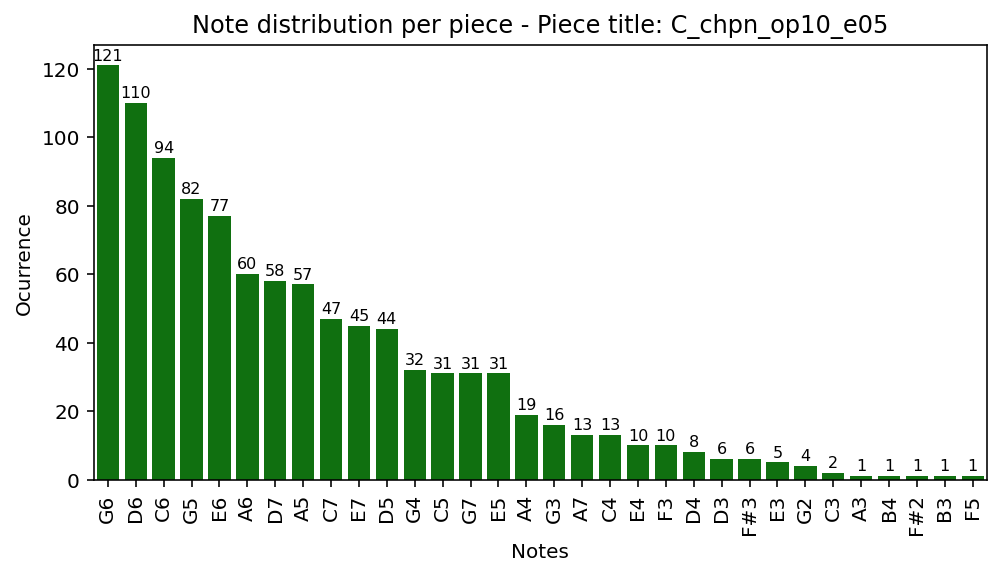

In [17]:
vis.plot_one_song(df_music["Notes"], df_music["Piece"], "C_chpn_op10_e05.mid", path_1)

## Pre-processing

### The relevant components from the MIDI file, for this project notes, rests and chords, have been extracted and saved in a list. To start training any neural network these information needs to be transformed from categorical data to integer-based numerical data. Therefore, it is necessary to create input sequences to feed into the network and their respective outputs. The output for each input sequence will be the first note or chord that is expected to come after the sequence of notes in the input sequence in the list of notes. 

### The length of each sequence will be 100 notes for now. This means that to generate the next note in the sequence the network has the previous 100 notes to help make the prediction. Another variable is the step which represents the amount of previous notes the next sequence will consider to predict the next one. These two variables can be adjusted depending on the model accuracy.

### If a long list is passed to the neural network the computer does not have the required memory to carry out all operations. To solve this issue without having to reduce the sequence length or another parameter it is possible to reduce the number of notes/chords given to the newtork based on its occurence in the piece. If a note does not appear more than the specified occurence value then it is removed from the list.

### If this solution does not resolve the memory issue, and other parameters (such as the sequence length or step) don't want to be changed, fewer pieces will need to be taken all at a time.

### To test the model the first trial considers only one piece: Chopin - Etude Op10 No4	


In [38]:
# one piece
x, y = md.prepare_sequences(pitchnames= pitchnames, notes=one_song, min_note_occurence=1, sequence_length=70, step=3)  

### As previously mentioned GAN models have also been used to generate melodies. Due to the different internal structure the pre-processing process is slightly different. GANs will be explained in more detail in the next section, for now it is just necessary to know that the main difference in the data pre-processing stage is that their network output needs to be a sequence of elements rathern than one element only so they need to be preprocessed with another function. 

### This will be better understood in the GAN section of the project.

In [39]:
# GAN baseline 
x_gan, y_gan = md.prepare_sequences_gan(pitchnames= pitchnames,notes=one_song, min_note_occurence=1, sequence_length=70, step=3) 

## Neural Network

### The pre-processed data has been split into network input and network output. During this process this data has also been encoded using one hot encoding system and it is ready to be used to train the models. 

### One hot encoding is used for categorical variables where no ordinal relationship exists. It creates a binary column for each category and returns a sparse matrix or dense array (depending on the sparse parameter).

### This section considers different models to not only generate new melodies but also to compare the effectiveness of each network. The chosen models are the following:
###    - Unidirectional LSTM 
###    - Bidirectional LSTM 
###    - Unidirectional LSTM with additional internal layers
###    - LSTM GAN
###    - Leaky Relu GAN


### All models will be explained first and then all their predictions will be listened to and compared. 

### Let's start analysing the first model. This baseline model is a recurrent network consisting of a LSTM layer which takes a sequence as an input and returns a matrix.


## Unidirectional LSTM model

### This model consists of one LSTM layers, one Dense layers and one activation layer. The network structure can be modified to improve the quality of the predictions. 

### The Dense layer is a fully connected neural network layer where each input node is connected to each output node, and the Activation layer determines what activation function will be used to calculate the output of a node. In this case the Activation function 'softmax' has been chosen to normalize the output of the network to a probability distribution over the predicted output classes. Each value in the output of the softmax function is interpreted as the probability of membership for each class.

### An optimizer is one of the two arguments required for compiling a Keras model. In this case the optimizer 'Adam' has been chosen as it is apropriate for non-stationary objectives. Instead of adapting the parameter learning rates based on the average first moment (the mean), Adam also makes use of the average of the second moments of the gradients (the uncentered variance).

### Another required value for compilation is the loss. The purpose of loss functions is to compute the quantity that a model should seek to minimize during training. Due to the model structure, and because labels are provided in a one_hot representation, 'Categorical Crossentropy' was selected as it computes the crossentropy loss between the labels and predictions.

In [40]:
# Baseline LSTM model considering one piece only - 1 epoch
model = m.lstm_model(num_units=x.shape[0], num_dense=x.shape[2], n_inputs=(x.shape[1],x.shape[2]))

In [41]:
# Baseline LSTM model - 1 epoch
model.fit(x, y, epochs=1, verbose=0)
# save the model
model.save(path_3 + "baseline_lstm_1epoch_1song_2.h5")
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 561)               2006136   
_________________________________________________________________
dense (Dense)                (None, 332)               186584    
_________________________________________________________________
activation (Activation)      (None, 332)               0         
Total params: 2,192,720
Trainable params: 2,192,720
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# load the model if required
# model = tf.keras.models.load_model(path_3 + "baseline_lstm_1epoch_1song_2.h5")

## Bidirectional LSTM model

### A Bidirectional LSTM model has been also created to compare its effectiveness against the basic LSTM model. The difference between these two models is that the Unidirectional LSTM only preserves information of the past because the only inputs it has seen are from the past. Bidirectional networks run inputs in two ways, preserving information from the past to future and from future to the past. 

### In theory the use of a Bidirectional LSTM model will improve predictions as it can generates melodies that sounds similar to humans. By keeping a more robust pattern in the melody the listener can expect what is next and feels that the piece structure makes more sense.

### To compare if this affirmation is true the same piece(s) and parameters used to train the Unidirectional LSTM model have been used for this model.


In [42]:
# Bidirectional LSTM model 1 piece - 1 epoch
model_bi = m.bi_lstm_model(num_units=x.shape[0], num_dense=x.shape[2], n_inputs=(x.shape[1],x.shape[2]))
model_bi.fit(x,y, epochs=1, verbose=0)
print(model_bi.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 70, 1122)          4012272   
_________________________________________________________________
dense_1 (Dense)              (None, 70, 332)           372836    
_________________________________________________________________
dropout (Dropout)            (None, 70, 332)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1122)              4012272   
_________________________________________________________________
dense_2 (Dense)              (None, 332)               372836    
_________________________________________________________________
dropout_1 (Dropout)          (None, 332)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 332)              

In [43]:
# save the model
model_bi.save(path_3 + "bi_lstm_1epoch_1song_2.h5")

## Upgraded LSTM Model 

### A third LSTM model has also been considered. This model has increased the number of LSTM and Dense layer to the baseline LSTM model. In additon to this, a Dropout layer has been added.

### The Dropout layer randomly selects neurons to be ignored during training. They are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass.

### It is a regularization technique which helps prevent overfitting.

### In this case this model consists of three LSTM layers, three Dense layers and two Dropout layers at 30% rate. 

In [44]:
lstm_upgraded = m.lstm_model_upgraded(num_units=x.shape[0], num_dense=x.shape[2], n_inputs=(x.shape[1],x.shape[2]))
lstm_upgraded.fit(x,y, epochs=1, verbose=0)
print(lstm_upgraded.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 70, 561)           2006136   
_________________________________________________________________
dense_3 (Dense)              (None, 70, 332)           186584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 70, 332)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 70, 561)           2006136   
_________________________________________________________________
dense_4 (Dense)              (None, 70, 332)           186584    
_________________________________________________________________
lstm_5 (LSTM)                (None, 561)               2006136   
_________________________________________________________________
dense_5 (Dense)              (None, 332)              

In [45]:
# save the model
lstm_upgraded.save(path_3 + "lstm_upgraded_1epoch_1song_2.h5")

## GANs

### Generative Adversarial Networks (GANs) are types of neural network architectures capable of generating new data that conforms to learned patterns.

### GANs are composed of two halves: a generation model and a discrimination model. The job of the generator model is to create new examples of data, based on the patterns that the model has learned from the training data. The job of the discriminator model is to analyze data and determine if they are generated/fake or genuine.

### The two models are faced against one another; The generator model's goal is to produce data that deceive the discriminator model. While the discriminator model's job is to overcome the generator model, and catch the generated/fake data that the generator produces. 

### This structure makes both models to improve. The discriminator gets feedback about which data is genuine and which one is produced by the generator, while the generator is fed information on which of its data were flagged as false by the discriminator. Both models improve during training, with the goal of training a generation model that can produce fake data that is basically indistinguishable from real, genuine data.

### The discriminator model is fed examples from the entire training domain, which is made up of both real and generated data examples. The real examples are contained within the training dataset, while the fake data is produced by the generative model. The process of training the discriminator model is exactly the same as basic, binary-classification model training.

<table align="center"> 
<tr><td width="800"><img src="../resources/gan.png" style="width:10;height:10"></td>  
</table>

### As two models are being faced there are more pre-processing processes required. 

### During the training process the GAN uses real data taken from the network input and generated / fake data produced by the generator. This fake data is generated from a random input. 

### 50% of real and 50% of fake data is fed into the discriminator model. It will then render a probabilistic prediction about the nature of the data it receives, outputting a value between 0 and 1, where 1 is typically authentic data and 0 is a fake data. 

### This system has a double feedback loop. Each training procedure has three steps per round and they can be done as many rounds as necessary. The first step is to assign random weights to the generator. It obviously produces very poor data that the discriminator model has no problem distinguishing it as fake. Therefore, the generator's parameters are updated.

### The next step is the discriminator round. Slighly improved data is generated by the generator model but the discriminator keep successfully categorising it as fake. However, in this case it is the discriminator model the one that is updated to improve even further. 

### In the last step real data is fed to the discriminator to learn what real data is.

### This cycle is repeated, mantaining the updates from the previous round, until the discriminator cannot discern between real or fake data and the generator cannot produced more realistic data. This means that the discriminator will always be rendering probabilities of 50% for real and fake samples, meaning generated / fake data are indistinguishable from the real one. 

## Data input

### Based on the GAN training procedure different network inputs are required. These are the real data, fake data and random input often called as latent points or latent space.

### Real data is a random portion taken from the original network input. This data is fed to the discriminator with a class label specifying they are real.

In [46]:
# The amount of samples can be changed to better tune the model
x_real, y_real = md.generate_real_samples(x_gan, n_samples=100,sequence_length=70)

### Latent points / random input is random noise. The generator then transforms this noise into a meaningful output. By introducing noise, the GAN produces a wide variety of data, sampling from different places in the target distribution.

In [47]:
# The amount of samples can be changed to better tune the model
x_latent = md.generate_latent_points(x_gan, n_samples=100)

### Fake data is taken from the random input, interpreted by the generator model, and then fed to the discriminator categorised as fake.

### As this type of data needs to be interpreted by the generator this model needs to be created first.

## LSTM GAN model

### The generator model is responsible for generating new plausible examples that ideally are indistinguishable from real data in the dataset.

### Two different GAN models will be used to compare which one generates the more realistic melody. The first one has been designed as simplest as possible to also be able to use it baseline. In this case, the generator only has one LSTM, Dense and Activation layer (Softmax). 

### The generator will only be trained through the GAN model so it is not necessary to compile it.

In [48]:
# Generator model
gen_model = m.generator_model(num_units= x_gan.shape[0], n_inputs=(x_gan.shape[1], x_gan.shape[2]))
gen_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 70, 538)           1874392   
_________________________________________________________________
dense_6 (Dense)              (None, 70, 332)           178948    
_________________________________________________________________
activation_3 (Activation)    (None, 70, 332)           0         
Total params: 2,053,340
Trainable params: 2,053,340
Non-trainable params: 0
_________________________________________________________________


### The discriminator model is responsible for classifying a given sample as either real (drawn from the dataset) or fake (generated).

### In this first GAN model the discriminator only has one LSTM, Dense and Activation layer. However, now the Activation function is "sigmoid" , which exists between 0 to 1. It is used because this model wants to predict the probability of the output and probability of anything exists only between the range of 0 and 1.

### The probabilistic loss in this model is 'binary crossentropy' as it computes the cross-entropy loss between true labels and predicted labels. It is used for binary (0 or 1) classification applications.

In [49]:
dis_model = m.discriminator_model(num_units= x_gan.shape[0], n_inputs=(x_gan.shape[1], x_gan.shape[2]))
dis_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 538)               1874392   
_________________________________________________________________
dense_7 (Dense)              (None, 332)               178948    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 333       
Total params: 2,053,673
Trainable params: 2,053,673
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Generate fake samples
x_fake, y_fake = md.generate_fake_data(x_gan, gen_model, n_samples=100)

### GAN model comprising both the generator and discriminator model.

In [51]:
gan_model = m.gan_model(gen_model, dis_model)
gan_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 70, 332)           2053340   
_________________________________________________________________
batch_normalization (BatchNo (None, 70, 332)           1328      
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 2053673   
Total params: 4,108,341
Trainable params: 2,054,004
Non-trainable params: 2,054,337
_________________________________________________________________


### Once both models have been created it is time to train the network.

### First, the discriminator model is updated for half batch of real samples, then half batch of fake samples, together forming one batch of weight updates. The generator is then updated via the combined GAN model. 

In [52]:
m.train(x=x_gan, g_model=gen_model, d_model=dis_model, gan_model=gan_model, n_epochs=1, n_batch=129,sequence_length=70)

>1, 1/4, loss_real=0.692, loss_fake=0.725 loss_latent=0.682
>1, 2/4, loss_real=0.621, loss_fake=0.684 loss_latent=0.663
>1, 3/4, loss_real=0.523, loss_fake=0.427 loss_latent=0.001
>1, 4/4, loss_real=1.824, loss_fake=0.145 loss_latent=0.251


In [53]:
# save the model
gan_model.save(path_3 + "model_gan_model_2.h5")
gen_model.save(path_3 + "model_gen_model_2.h5")
dis_model.save(path_3 + "model_dis_model_2.h5")

## Leaky GAN model

### Another type of network has been tested for this project. In this case a LeakyRelu layer has been used. 

### It allows a small gradient when the unit is not active. There is a small negative slope, so instead of not firing at all for large gradients, neurons output some value making the layer much more optimized too.

### The derivative is 1 in the positive part, and is a small fraction in the negative part.

### In addition, few layers of Batch Normalization have also been included. It is a layer that normalizes its inputs. It is a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.

In [54]:
# Generator Leaky Relu model
gen_model_leaky = m.generator_model_Leaky(n_nodes= x_gan.shape[0] , n_inputs=(x_gan.shape[1], x_gan.shape[2]))
# Discriminator 
dis_model_leaky = m.discriminator_model_Leaky(num_units= x_gan.shape[0], n_inputs=(x_gan.shape[1], x_gan.shape[2]))
# Gan combined
gan_model_leaky = m.gan_model(gen_model_leaky, dis_model_leaky)

gen_model_leaky.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 70, 538)           179154    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 70, 538)           0         
_________________________________________________________________
dense_10 (Dense)             (None, 70, 538)           289982    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 70, 538)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 70, 538)           2152      
_________________________________________________________________
dense_11 (Dense)             (None, 70, 332)           178948    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 70, 332)          

In [55]:
# Train
m.train(x=x_gan, g_model=gen_model_leaky, d_model=dis_model_leaky, gan_model=gan_model_leaky, n_epochs=1, n_batch=129,sequence_length=70)

>1, 1/4, loss_real=0.662, loss_fake=0.766 loss_latent=0.460
>1, 2/4, loss_real=0.000, loss_fake=0.702 loss_latent=0.168
>1, 3/4, loss_real=0.000, loss_fake=0.641 loss_latent=0.029
>1, 4/4, loss_real=0.000, loss_fake=0.573 loss_latent=0.003


In [56]:
gen_model_leaky = tf.keras.models.load_model(path_3 +"model_gen_leaky_2.h5")
gen_model_leaky.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 70, 538)           182920    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 70, 538)           0         
_________________________________________________________________
dense_7 (Dense)              (None, 70, 538)           289982    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 70, 538)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 70, 538)           2152      
_________________________________________________________________
dense_8 (Dense)              (None, 70, 339)           182721    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 70, 339)          

In [39]:
# save the model
gan_model_leaky.save(path_3 + "model_gan_leaky_2.h5")
gen_model_leaky.save(path_3 + "model_gen_leaky_2.h5")
dis_model_leaky.save(path_3 + "model_dis_leaky_2.h5")


## Model Comparison

### Train the model considering only 1 epoch (iteration). This variable can be adjusted to improve the quality of predictions. Future trials will increase this value to compare model results.

### The network loss, accuracy and root mean squared error are inserted into a dataframe to be able to compare different models.

In [34]:
# Baseline LSTM model
result_errors = model.evaluate(x, y, verbose=0)

# Bidirectional LSTM model
result_errors_bi = model_bi.evaluate(x, y, verbose=0)

# Upgraded LSTM model
result_errors_up = lstm_upgraded.evaluate(x, y, verbose=0)

print(f"LSTM model evaluation:\n- Loss: {result_errors[0]}\n- Accuracy: {result_errors[1]}\n- RMSE: {result_errors[2]}")
print("")
print(f"Bidirectional LSTM model evaluation:\n- Loss: {result_errors_bi[0]}\n- Accuracy: {result_errors_bi[1]}\n- RMSE: {result_errors_bi[2]}")
print("")
print(f"Upgraded LSTM model evaluation:\n- Loss: {result_errors_up[0]}\n- Accuracy: {result_errors_up[1]}\n- RMSE: {result_errors_up[2]}")


LSTM model evaluation:
- Loss: 0.6070066094398499
- Accuracy: 0.028520498424768448
- RMSE: 0.034225184470415115

Bidirectional LSTM model evaluation:
- Loss: 0.7158117890357971
- Accuracy: 0.01247771829366684
- RMSE: 0.03345061093568802

Upgraded LSTM model evaluation:
- Loss: 0.6906465291976929
- Accuracy: 0.008912655524909496
- RMSE: 0.03464468568563461


### GAN accuracy 

In [40]:
# Accuracy
check_performance = m.check_performance(gen_model, dis_model, x_gan, sequence_length = 70, n_samples=100)
check_performance_leaky = m.check_performance(gen_model_leaky, dis_model_leaky, x_gan, sequence_length = 70, n_samples=100)

print(f"GAN model evaluation:\n- Accuracy: {check_performance}")
print("")
print(f"GAN LeakyRelu model evaluation:\n- Accuracy: {check_performance_leaky}")


GAN model evaluation:
- Accuracy: >Accuracy real: 87%, fake: 100%

GAN LeakyRelu model evaluation:
- Accuracy: >Accuracy real: 100%, fake: 100%


### To make a clearer comparison between all models their parameters and evaluation has been included in a dataframe.

## Comparison

In [ ]:
# Dataframe with model information
models = ["LSTM", "Bidirectional LSTM", "LSTM Upgraded", "Baseline GAN", "Leaky GAN"]
params = ["1 epoch, loss=categorical_crossentropy, optimizer=rmsprop", "1 epoch, loss=categorical_crossentropy, optimizer=rmsprop","1 epoch, loss=categorical_crossentropy, optimizer=rmsprop", "1 epoch, loss=binary_crossentropy, optimizer=adam", "1 epoch, loss=binary_crossentropy, optimizer=adam"]
loss = [result_errors[0], result_errors_bi[0], result_errors_up[0], np.nan, np.nan]
acc = [result_errors[1], result_errors_bi[1], result_errors_up[1], check_performance, check_performance_leaky]
rmse = [result_errors[2], result_errors_bi[2],result_errors_up[2], np.nan, np.nan]

df_error = pd.DataFrame({"model": models, "parameters": params, "loss": loss, "rmse": rmse, "accuracy": acc})
df_error


,model,parameters,loss,rmse,accuracy
0,LSTM,"1 epoch, loss=categorical_crossentropy, optimi...",4.536096,0.054373,0.027223
1,Bidirectional LSTM,"1 epoch, loss=categorical_crossentropy, optimi...",4.369243,0.054193,0.114338
2,LSTM Upgraded,"1 epoch, loss=categorical_crossentropy, optimi...",4.704911,0.054544,0.018149
3,Baseline GAN,"1 epoch, loss=binary_crossentropy, optimizer=adam",NaN,NaN,">Accuracy real: 94%, fake: 100%"
4,Leaky GAN,"1 epoch, loss=binary_crossentropy, optimizer=adam",NaN,NaN,">Accuracy real: 100%, fake: 100%"


### Save dataframe for its possible future use

In [ ]:
# save the results dataframe
md.save_dataframe(path_5, df_error, "df_results")

'Your file has been saved'

### Insert dataframe into SQL

In [ ]:
# insert into SQL the results dataframe 

a.upload_comparison_dataframe(path_5, "df_results")         

In [9]:
# clean garbage
import gc
gc.collect()

20

## Predictions

### Once the model has been trained, some post-processing operations are required to be able to make predictions. 

### To make a prediction a full list of note sequences is chosen using a random index in the original list. This allows to re-run the generation code without changing anything and get different results every time. Contrary to the first process done, a mapping function here will decode the output of the network. This function will transform from numerical data (integers) to categorical data (notes).

### For each predicted note that we want to generate we have to submit a sequence to the network. 

### A sequence to the network is fed for each generated note. The first submitted sequence is the sequence of notes at the starting index. A sliding-window method is applied and every subsequent sequence is the output of the previous iteration without the first note. To determine the most likely prediction from the output the index of the highest value is considered and then decoded to represent its note, rest or chord.

### The amount of generated notes can be chosen, for reference 500 notes is roughly two minutes of music.

### To try to improve predictions differente temperatures can be used. Temperature is a hyperparameter of neural networks used to control the randomness of predictions by scaling the logits before applying softmax. 

### Using a higher temperature value produces a softer probability distribution over the classes, and makes the neural network less conservative in its samples, resulting in more diversity and also more mistakes.

In [22]:
# Baseline LSTM model - 1 epoch
prediction_output, patterns = md.generate_notes(pitchnames=pitchnames, notes=one_song, model=model, sequence_length=70, temperature=1.0)
print(prediction_output)

['9.0.4', '7.9.1', 'D4', '11.2.5', '4', 'D4', '9.0', '7', 'D4', 'REST', 'E4', 'B2', 'F4', '8.10', '9', '6.9', 'F5', 'E2', '10.1.5', 'D5', 'C7', '6.9.1', 'G#4', '5.11', 'F2', 'REST', 'A1', 'B2', '10', 'B4', 'F2', 'C5', 'B2', 'B2', 'A1', '11', 'C3', '0.3', 'REST', 'C#2', 'B2', 'D4', 'G5', 'D5', '5.7.11.1', 'A5', 'REST', '5.8', 'F2', 'A2', '8.11.2.4', 'E4', 'E5', '9.0', '5.11', 'A4', '9', 'G#4', 'B2', 'E-5', '4.5', 'B2', '9', 'D4', '9.0', 'F3', '1.4', '8.9', 'A4', '8.10', 'F#5', '9.11.3', '9.2', '4.10', 'A3', '3.5.9', 'B2', 'D4', '0.3', 'E-5', 'REST', '2.5.8', 'G3', '4.7.8', '8.11', 'E4', '6', 'A4', '2', 'A2', 'D5', '9.2', '4.7.10', '11.2', '0.3', '11.4', '11', 'B3', '10.0', 'D4']


In [28]:
# Bidirectional LSTM model - 1 epoch
prediction_output_bi, patterns_bi = md.generate_notes(pitchnames=pitchnames, notes=one_song, model=model_bi, sequence_length=70, temperature=1.0)
print(prediction_output_bi)

['F#6', 'F6', '8.11', 'C5', '6.11', 'A5', 'A4', 'F4', 'G#2', '7.0', 'C#1', 'A5', 'D2', 'G#4', 'C5', 'C2', 'E3', '5.8.0', '8.11.2.4', 'C2', 'F4', '4.8.11', '11.4.5', 'B4', 'D4', 'D2', 'D2', 'E2', 'B-4', '8', '8', 'D5', 'A4', '0.6', 'G2', 'F4', 'G#4', 'C#3', 'G1', 'C5', '11', 'D4', '9.11.2.5', 'D2', '0.4', 'B-4', 'C#3', 'F4', 'C2', '9', 'F4', 'C#4', 'C2', 'F4', '0.3', 'REST', 'B2', '11.2.4', '8.0', 'F6', 'D4', 'G#2', 'F#3', '2.6', 'G#1', '4.8', 'G4', 'D4', 'G#6', 'C5', 'F#3', '5', 'F#4', 'F4', '2.8', 'REST', '5.6.11', '4.10', 'D7', '1.5', '4.9', 'E3', '10.2', 'G1', '7.10.0', 'C#3', '10.1.5', 'E-6', 'E3', '4.8', 'G1', '2.5.8.11', 'G1', 'REST', 'F#2', 'G#5', '1.3', 'D2', 'E6', '7.0']


In [29]:
# Upgraded LSTM model - 1 epoch
prediction_output_upgraded, patterns_upgraded = md.generate_notes(pitchnames=pitchnames, notes=one_song, model=lstm_upgraded, sequence_length=70, temperature=1.0)
print(prediction_output_upgraded)

['F#3', '0.2', 'B-2', 'F6', 'D3', '7.8.11.2', '5.11', '7.10.2', 'D4', 'G1', 'REST', 'G2', 'F5', '2.5.7', 'REST', '7', 'F5', '0', 'REST', 'G#3', '1.4.7.10', 'B4', 'G#4', '10.2', 'E-5', 'C#2', '5.8.11', 'E2', 'G6', 'E4', 'D2', 'REST', '2.5.8.11', 'C5', 'C#3', 'G#4', 'F6', '0.2.6', 'F3', 'E2', 'C2', '4.9', 'F5', 'E4', 'B5', 'B2', 'C5', 'F#3', '5.9', 'F6', 'E2', 'F#2', 'F5', '6.10', 'A3', 'E2', 'F#2', 'F5', '10.3', 'E-5', 'E-3', 'C2', 'D2', 'C#3', 'E2', '8.11', '0.4.7', 'E4', 'C5', '2.5.8.11', 'C2', '8.11', 'B4', '1.4', 'B6', '4', '0.4.7', '8.11', '5.8', 'E-3', 'C#5', '4.7.10', 'D1', 'E-5', '11.3', 'G#2', '3.7.10', 'E2', '3.7', 'C#5', 'C5', 'D2', 'C2', 'C2', '4.7', '8.0.3', 'C1', 'D2', 'F5', 'A3']


In [30]:
# Baseline GAN - 1 epoch
prediction_output_gan, patterns_gan = md.generate_notes_gan(pitchnames=pitchnames, notes=one_song, model=gen_model, sequence_length=70, temperature=1.0)
print(prediction_output_gan)

['11.4', '1.5.7', '3.6.7', '5.7.0', '3.5.8.10', 'E-3', 'G4', '0.4.7', '9.10.2', '5.8.9', '7.8.0', '1.3.8', 'A2', '10.1.4.6', '8.10.3', '1.5.9', '4.8', '9', 'A1', '6.8.1', '10', '0.2.4', '10', '7.9.2', '0.1', 'B-2', 'E-3', '9.1', 'F#1', '10.0', '0.3.6.7', 'E5', '5.9.10', '1.5.8', '4.8.11', '2.7', '9.10', '9.11.4', '3.6.9', '2.5.8.11', '10.0', '6.11.0', '4.7.10.0', '3.6.7', '0.4.8', '8.11.1', '5.6', '9.2', '3.4.9', '5.8', '4.8.11.0', 'A2', '3.5.10', '3.5.10', 'B2', 'A5', 'G#4', '4.7.9', 'A5', 'G5', '9.11.2.5', '4.7.9.0', 'A0', '5.8.11.1', '1.4.7', '3.5.8', 'A4', '3.4.9', '11.2.5.7', 'G4']


In [ ]:
# Baseline GAN LeakyRelu- 1 epoch
prediction_output_gan_leaky, patterns_gan_leaky = md.generate_notes_gan(pitchnames=pitchnames, notes=one_song, model=gen_model_leaky, sequence_length=70, temperature=1.0)
print(prediction_output_gan_leaky)

['F#2', 'E-6', '0.5', 'C4', '3.7.9', 'G3', '3.6.8', '4.9.10', 'B-5', '11.3.6', 'B5', '7.9.1', '2.5', '10', '4.5', 'F#7', '1.4.7.9', 'G5', 'A3', '2.6.9', 'F#4', 'G5', 'E2', 'G7', '9.11.1', '4.6.9', 'E6', 'D4', '4.7.10', 'E7', '8.10.3', '6.9.0.2', 'G7', '3.7', '0.2.6.8', '10.1.4', 'E-2', '0.2.6.8', '4.9', '1.4.7.9', '8.9.0.3', '6.11', '1.5.8', 'F#7', '3.7', '4.5.7.11', 'REST', '5.7.10', 'A7', '2.5', '2.4.5.9', 'B3', '1.4.7', '0.2.5', '11.1', 'G3', '1.5.9', '9.11.2.5', '3.4.9', '8.11', '1.3.7', 'G4', '8.0.2', '0.3.6', '9.0.2.5', '3.7.11', '6.7', '4.9.10', '6.7', '4.6.11']


## Post-Processing

### Now that an array full of predicted notes have been generated it is time to decode it. Its elements can be notes, rests or chords.

### If the patter is a note or a rest it will be decoded using the note and rest object respectively from the librery Music21. It it is a chord, it will be split into an array of notes. Each note will be converted using the note object and then compiled into the chord object considering those notes.

### At the end of this decodification a MIDI file is created with these objects to be able to listen to the model predictions.

In [ ]:
# Baseline LSTM model - 1 epoch
md.gen_midi(prediction_output, path_4, "baseline_lstm_1epoch_1song_4.mid")
# Bidirectional LSTM model - 1 epoch
md.gen_midi(prediction_output_bi, path_4, "bi_lstm_1epoch_1song_4.mid")
# Upgraded LSTM model - 1 epoch
md.gen_midi(prediction_output_upgraded, path_4, "upgraded_lstm_1epoch_1song_3.mid")
# Baseline GAN - 1 epoch
md.gen_midi(prediction_output_gan, path_4, "gan_lstm_1epoch_1song_3.mid")
# GAN LeakyRelu - 1 epoch
md.gen_midi(prediction_output_gan_leaky, path_4, "gan_leaky_lstm_1epoch_1song_3.mid")

<music21.stream.Stream 0x23503f1c448>

### The below function allows to play the generated MIDI files in the notebook

### Just for comparison this is the first created MIDI file was just one note repeated over 2 minute time.

In [11]:
md.play_music(path_4 + "1st_baseline_lstm_10epoch_1song_1.mid")

### After adjusting the pre and post processes, as well as the neural network more interesting melodies were generated.

In [ ]:
# Plays music when the below cells are executed 

In [ ]:
# Baseline LSTM model - 1 epoch
md.play_music(path_4 + "baseline_lstm_1epoch_1song_3.mid")

In [ ]:
# Bidirectional LSTM model - 1 epoch
md.play_music(path_4 + "bi_lstm_1epoch_1song_3.mid")

In [ ]:
# Upgraded LSTM model - 1 epoch
md.play_music(path_4 + "upgraded_lstm_1epoch_1song_2.mid")

In [31]:
# Baseline GAN - 1 epoch
md.play_music(path_4 + "gan_lstm_1epoch_1song_2.mid")

In [44]:
# GAN LeakyRelu - 1 epoch
md.play_music(path_4 + "gan_leaky_lstm_1epoch_1song_2.mid")

### The above output sounds almost identically, though it was seen from the predictions that they consist on different notes. The reason can be that all models didn't have enough time to be trained and a small list of notes were provided as an input due to software memory issues.

### Now that we know that the neural network structure works all parameters can be adjusted to maximise predictions. For now and to keep this project simple the baseline LSTM model will be used to generate more new melodies as it has proved that it is as effective as the rest and it takes the least amount of time to make predictions.

In [12]:
# If more melodies want to be generated the model can be called directly without having to execute all the notebook.
model = tf.keras.models.load_model(path_3 + "baseline_lstm_1epoch_1song_2.h5")

## Time to have fun

### Though the models have been trained to predict classical music from one isntrument, they were also tested with more variety of songs        

In [31]:
# The melody will play when the cell is executed, also its MIDI file is automatically saved to the folder 'reports'
#md.process_and_execute(path_1, path_2, path_3, path_6, pitchnames, path_4, name="Guns n Roses - Sweet Child O Mine", output_name="GunsnRoses")

# To avoid overwrite the file it can be loaded back.
# This melody has been generated with the song Sweet Child of Mine by Guns and Roses:
md.play_music(path_4 + "GunsnRoses.mid")

In [32]:
#process_and_execute(name="Never-Gonna-Give-You-Up-1", output_name="GiveUp")

# To avoid overwrite the file it can be loaded back.
# This melody has been generated with the song Never gonna with you up:
md.play_music(path_4 + "GiveUp.mid")

In [60]:
# The melody will play when the cell is executed, also its MIDI file is automatically saved to the folder 'reports'
md.process_and_execute(p1=path_1, p2=path_3, p3=path_6, p4=pitchnames, p5=path_4, p6=path_2, name="Naruto - sadness and sorrow", output_name="Naruto")
# This melody has been generated with the song Never gonna with you up:
#md.play_music(path_4 + "Naruto.mid")

563


## Conclusion

### This one-week project has proved that deep learning is capable of generating new melodies. Though results are far from perfect it is still impressive what a shallow neural network and a simple GAN network are capable to do. 

### **What can you conclude about your data study?**
### The study concludes that artificial intelligence can generate new melodies. Now it is only required to invest more time and research to improve the selected models to improve the predictions. There are differente ideas, all explained in the below section "future steps" that can be carried out to improve the study. 

### **What would you change if you needed to do another DS project?**
### With the available time and software the results were already capped off before even the analysis was started. 
### More time is required to use a GAN model. Their internal structure is complicated and results won't be optimised unless all parts are completely understood.

### **What do you learn doing this project?**
### Investigation is key when using neural network as increasing internal layers or modifying some parameters did not improve, or at least significantly, the generated melody. To obtain further improvements it is necessary to have a better understanding of this internal structure and all their available options.
### Additionally, more time or a more robust software would be preferable to test models as the training process can be very time-consuming.

### At last the below pit chart ilustrates the approximate distribution of time spent in the project. There have been more sections that are not shown here to not overcrowd the chart.

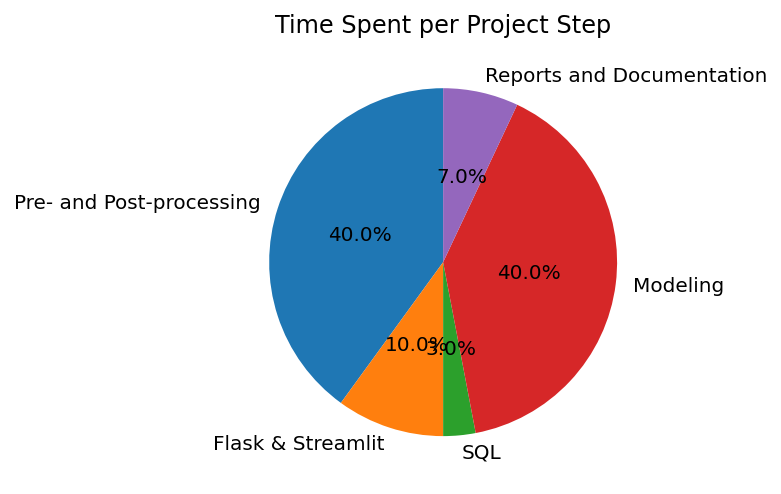

In [42]:
# Time spent in each project step
vis.piechart(path_4)

## Future steps

### Different alternatives and additional work can always be done to improve this work. Due to the available time and resources it was not possible to implement all ideas. Some of them that can contribute to the improvement of the predictions are listed below:

### - Change time signature to 4/4 to achieve more consistancy to the input and ease patterns
### - Keep the length of all pieces the same
### - Try more parameters and layers to all networks. However, deeper networks also required a more powerful computer.
### - Play around with the number of epoch and batches to optimised results
### - Train the model with files consisting of different instruments
### - Clean the data based on sound frequency
### - Convert MIDI files to WAV files automatically in Python
### - Use Selenium to be able to automatically make predictions in Streamlit. Currently this is not possible as MIDI files cannot be uploaded and the conversion to WAV is done manually.